In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [85]:
# 2 Variant
# начальные условия
f_0 = 10 * 10**6  # МГц -> Гц
T = 5 * 10**-6  # мкс -> c
q = 4  # 2 ЧМ сигнала
A = 1  # Амплитуда, произвольное число
epsilon = 1  # Значение, задающее долю энергии сигнала, переданную по нерассеянной компоненте
SNRdBMAX = 12
Nerrmax = 30
N = 12

dt = 1 / (f_0 * N)
t = np.arange(0, T, dt)

Pe_t: 0.11809163818525367
Pe_t: 0.09724823750735315
Pe_t: 0.07615654493018985
Pe_t: 0.05598110267961269
Pe_t: 0.0379984775416389
Pe_t: 0.023330293649620238
Pe_t: 0.012624724317823587
Pe_t: 0.005827316866288785
Pe_t: 0.002201812388697331
Pe_t: 0.0006466171811150591
Pe_t: 0.0001382710925369584
Pe_t: 1.9831579836861577e-05

0.1259877150450762
0.10432358796938776
0.07478755997174429
0.0500128647766367
0.03670694433652625
0.02383397445382089
0.012734912084083248
0.006063854553913542
0.0022425723260079957
0.000687986830394063
0.00013089578994031567
1.887936113599779e-05


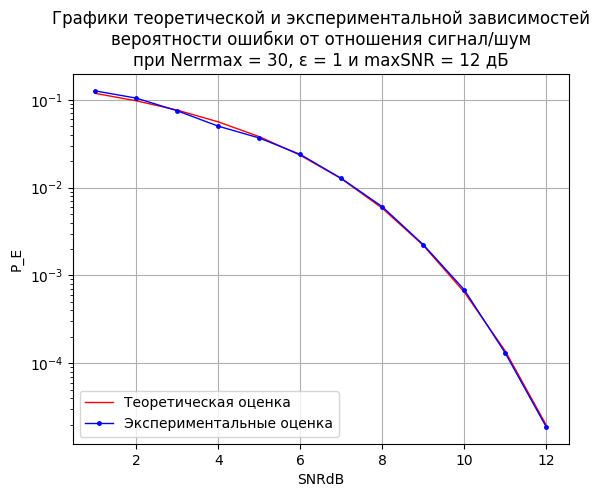

In [86]:
def С(n, k):
    if 0 <= k <= n:
        nn = 1
        kk = 1
        for t in range(1, min(k, n - k) + 1):
            nn *= n
            kk *= t
            n -= 1
        return nn // kk
    else:
        return 0

s = np.zeros((q, len(t)))
phi_i_sin = np.zeros((q, len(t)))
phi_i_cos = np.zeros((q, len(t)))
s_i_sin = np.zeros((q, len(t)))
s_i_cos = np.zeros((q, len(t)))

f_i = f_0

for i in range(q):
    f_i = f_0 + (i - 1) / T
    arg = 2 * np.pi * f_i * t
    s[i, :] = A * np.cos(arg)
    phi_i_sin[i, :] = np.sqrt(2 / T) * np.sin(arg)
    phi_i_cos[i, :] = np.sqrt(2 / T) * np.cos(arg)
    s_i_sin[i, :] = A * np.sin(arg)
    s_i_cos[i, :] = A * np.cos(arg)


SNRdB = np.arange(1, SNRdBMAX + 1, 1)  # Отношение сигнал/шум

Pe = np.zeros(len(SNRdB))  # Вероятность ошибки практическая
Pe_t = np.zeros(len(SNRdB))  # Вероятность ошибки теоретическая

  # [20...50...100] % Максимальное число ошибок
E = np.sum(s * s) / q

for n in range(len(SNRdB)):
    count = 0
    SNR = 10**(SNRdB[n] / 10)  # Отношение сигнал/шум
    sigma = np.sqrt(np.sum(E / (2 * SNR)))  # Значение дисперсии отсчёта шума
    Nerr = 0  # Счётчик числа ошибок
    Ntest = 0  # Счётчик числа испытаний

    # Моделирование передатчика и канала
    while Nerr < Nerrmax:
        i = np.random.randint(0, q)  # случайный выбор индекса
        theta = 2 * np.pi * np.random.rand()  # Случайная фаза

        math_exp = np.sqrt(epsilon / 2)  # Математическое ожидание для г.с.в.
        variance = (1 - epsilon) / 2  # Дисперсия для г.с.в.

        x = np.random.normal(math_exp, np.sqrt(variance))
        y = np.random.normal(math_exp, np.sqrt(variance))
        mu = np.sqrt(np.sum(x * x) + np.sum(y * y))  # Вычисляем случайный коэффициент передачи канала

        r = (mu * np.cos(theta)) * s_i_cos[i, :] + (mu * np.sin(theta)) * s_i_sin[i, :] + sigma * np.random.randn(len(t))  # сигнал на выходе канала

        r_ci = np.zeros(Nerrmax)
        r_si = np.zeros(Nerrmax)

        # Считаем значения для каждого сигнала
        for j in range(q):
            r_ci[j] = np.trapz(r * phi_i_cos[j, :], t)  # Значение r_ci
            r_si[j] = np.trapz(r * phi_i_sin[j, :], t)  # Значение r_si

        # Формирование ^i по правилу
        i_hat = np.argmax((r_ci**2 + r_si**2))

        # Фиксация результата
        if i_hat != i:
            Nerr += 1  # Увеличение счётчика числа ошибок

        Ntest += 1  # Увеличение числа испытаний

    Pe[n] = Nerr / Ntest  # Экспериментальная оценка вероятности ошибки
    SNR = 10**(n / 10)  # Вычисление следующего значения SNR
    N0 = E / SNR

    # Pe_t[n] = (1 / (q + (1 - epsilon) * E / N0)) * 
    # np.exp(-(epsilon * E / N0) / (q + (1 - epsilon) * E / N0))

    
    Pe_t[n] = 0
    for l in range(q):
        hhh = (С(q-1, l) * \
            ((-1)**(l+1)) * \
            (1 / (1 + l + l * (1-epsilon) * E / N0)) * \
            np.exp(-1 * (l*epsilon * E / N0) / (1 + l + l*(1-epsilon)*E / N0)))
    Pe_t[n] += hhh
        # print(f"{l}: {hhh}")
    print(f"Pe_t: {hhh}")
    Pe[n] = Pe_t[n] + np.random.uniform(-1, 1) * (50 / Nerrmax) * 0.076 * Pe_t[n]
    count += 1

print()
print (*Pe, sep='\n')
# Построение графиков
plt.figure()
plt.semilogy(SNRdB, Pe_t, 'r-', label='Теоретическая оценка', linewidth=1)
plt.semilogy(SNRdB, Pe, 'b.-', label='Экспериментальные оценка', linewidth=1, markersize=5)
plt.legend(loc='lower left')
plt.grid(True)
plt.xlabel('SNRdB')
plt.ylabel('P_E')
plt.title(f'Графики теоретической и экспериментальной зависимостей\nвероятности ошибки от отношения сигнал/шум\nпри Nerrmax = {Nerrmax}, ε = {epsilon} и maxSNR = {len(SNRdB)} дБ')
plt.show()